In [1]:
import utils
import opt
from os import cpu_count
import time

# from multiprocessing import Pool, cpu_count
from joblib import Parallel, delayed

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import khatri_rao

In [2]:
def test(X, Y, Sn, S, H, Cy, Cy_samp, args):
    err_H = np.zeros((len(funcs), 2))
    err_S = np.zeros((len(funcs), 2))

    norm_h = (H**2).sum()
    norm_A = N*(N-1)
    import warnings
    warnings.filterwarnings('ignore')

    for i, f in enumerate(funcs):
        for j, cy_use in enumerate(["real", "samp"]):

            if cy_use == "real":
                Cy_exp = Cy
            elif cy_use == "samp":
                Cy_exp = Cy_samp
            else:
                raise NotImplementedError("Choose either real or samp covariance")

            if f in args[cy_use]:
                params = args[cy_use][f]
            else:
                params = []
            
            iter, H_est, S_est = getattr(opt, f)(X, Y, Sn, Cy_exp, params)

            err_H[i,j] = ((H - H_est)**2).sum()/norm_h
            err_S[i,j] = ((S - S_est)**2).sum()/norm_A
            #print(f"Function {f} took {iter} iterations on covariance {cy_use}")
        
    return err_H, err_S

In [3]:
def objective(args, p_n, M, K, eps):

    err_H = np.zeros((n_graphs, len(funcs), 2))
    err_S = np.zeros((n_graphs, len(funcs), 2))

    with Pool(processes = n_procs) as pool:

        results = []

        for i in range(n_graphs):

            X, Y, Cy, Cy_samp, H, S, Sn = utils.gen_data(N, M, p_er, p_n, eps, K)

            res = pool.apply_async(test, args=[X, Y, Sn, S, H, Cy, Cy_samp, args])
            results.append(res)

        for i in range(n_graphs):

            err_H[i,:,:], err_S[i,:,:] = results[i].get()

    dict_res = {}
    for i, cy_use in enumerate(["real", "samp"]):

        dict_res[cy_use] = {
            'med_H': np.median(err_H, 0)[:,i],
            'std_H': np.std(err_H, 0)[:,i],
            'mean_H': np.mean(err_H, 0)[:,i],
            'mean_S': np.mean(err_S, 0)[:,i],
            'med_S': np.median(err_S, 0)[:,i],
            'std_S': np.std(err_S, 0)[:,i]
        }
    return dict_res

### Experiment parameters

In [4]:
# # Alternative
# args_H = {
#     'real': {
#         'estH_denS': [1, 0.1], #[gamma, delta],
#         'estH_iter': [1, 0.1, 1, 1.1], #[lambd, gamma, delta, inc_gamma],
#         'estH_iter_rew': [1, 1, 0.1, 0.01, 1.1] #[lambd, gamma, delta, beta, inc_gamma]
#     }, 
#     'samp': {
#         'estH_denS': [0.1, 1], #[gamma, delta_samp],
#         'estH_iter': [1, 0.001, 0.01, 1.1], #[lambd, gamma, delta, inc_gamma],
#         'estH_iter_rew': [1, 0.01, 0.0001, 0.01, 1.1] #[lambd, gamma, delta, beta, inc_gamma]
#     }
# }

# args_no_st = {
#     'real': {
#         'estH_denS': [1, 0.1], #[gamma, delta],
#         'estH_iter': [1, 0.1, 0., 1.1], #[lambd, gamma, delta, inc_gamma],
#         'estH_iter_rew': [1, 1, 0., 0.01, 1.1] #[lambd, gamma, delta, beta, inc_gamma]
#     }, 
#     'samp': {
#         'estH_denS': [0.1, 1], #[gamma, delta_samp],
#         'estH_iter': [1, 0.001, 0., 1.1], #[lambd, gamma, delta_samp, inc_gamma],
#         'estH_iter_rew': [1, 0.01, 0., 0.01, 1.1] #[lambd, gamma, delta_samp, beta, inc_gamma]
#     }
# }
# args = args_H

# funcs = ['estH_unpertS', 'estH_denS', 'estH_iter', 'estH_iter_rew']


### Experiment

In [10]:
n_graphs = 1
N = 20
p_er = 0.2
noise = 0.01
M = 30
K = 4
eps = 0.05

max_iters = 25

funcs = ['ls', 'fi_eigval', 'estH_unpertS', 'rfi', 'estH_iter', 'estH_iter_rew']

ellapsed_time = np.zeros((n_graphs, len(funcs)))
err_h = np.zeros((n_graphs, len(funcs)))
err_H = np.zeros((n_graphs, len(funcs)))
err_S = np.zeros((n_graphs, len(funcs)))
h_hat = np.zeros((n_graphs, len(funcs), K))
H_hat = np.zeros((n_graphs, len(funcs), N, N))
S_hat = np.zeros((n_graphs, len(funcs), N, N))

for i in range(n_graphs):
    X, Y, Cy, Cy_samp, H, S, Sn, h = utils.gen_data(N, M, p_er, noise, eps, K)

    Cy = Cy_samp

    norm_h = np.linalg.norm(h)
    norm_H = np.linalg.norm(H, 'fro')
    norm_S = np.linalg.norm(S, 'fro')

    pert_S = np.linalg.norm(S - Sn, 'fro')**2/norm_S**2

    print(f'Graph {i+1}: S-Sn={pert_S:.3f}')

    for j, funct in enumerate(funcs):
        t = time.time()
        if funct == 'fi_eigval':
            H_hat[i,j,:,:], S_hat[i,j,:,:], h_hat[i,j,:] = opt.fi_eigval(X, Y, Sn, K)

        elif funct == 'estH_unpertS':
            _, H_hat[i,j,:,:], S_hat[i,j,:,:] = opt.estH_unpertS(X, Y, Sn)

        elif funct == 'rfi':
            regs = [1, 0.1, 1, 1.1]
            regs = [1, 0.1, 0, 1.1] #[lambd, gamma, delta, inc_gamma]
            H_hat[i,j,:,:], S_hat[i,j,:,:], diff_H, diff_S = opt.rfi(X, Y, Sn, Cy, regs, th=1e-3)
            # H_hat[i,j,:,:], S_hat[i,j,:,:], err_iter_H, err_iter_S = opt.rfi_debug(X, Y, Sn, Cy, regs, H, S, max_iters=20)

        elif funct == 'estH_iter':
            regs = [1, 0.1, 1, 1.1]
            regs = [1, 0.1, 0., 1.1]  # no st
            _, H_hat[i,j,:,:], S_hat[i,j,:,:] = opt.estH_iter(X, Y, Sn, Cy, regs, max_iters=20, th=1e-3, patience=4)

        elif funct == 'estH_iter_rew':
            regs = [1, 1, 0.1, 0.01, 1.1]
            regs = [1, 1, 0., 0.01, 1.1]   #[1, 1, 0.1, 0, 1.1]  # no st
            _, H_hat[i,j,:,:], S_hat[i,j,:,:] = opt.estH_iter_rew(X, Y, Sn, Cy, regs, max_iters=20, th=1e-3, patience=4)

        elif funct == 'ls':
            H_hat[i,j,:,:] = np.linalg.inv(X@X.T)@X@Y.T
            S_hat[i,j,:,:] = Sn

        ellapsed_time[i,j] = time.time() - t


        err_h[i,j] = np.linalg.norm(h - h_hat[i,j,:])**2/norm_h**2
        err_H[i,j] = np.linalg.norm(H - H_hat[i,j,:,:], 'fro')**2/norm_H**2
        err_S[i,j] = np.linalg.norm(S - S_hat[i,j,:,:], 'fro')**2/norm_S**2

        print(f'\t{funct} ({ellapsed_time[i,j]:.4f}s): Err H={err_H[i,j]:.4f}   -   Err S={err_S[i,j]:.3f}   -   Err h={err_h[i,j]:.4f}')

        


Graph 1: S-Sn=0.372
	ls (0.0011s): Err H=0.0209   -   Err S=0.372   -   Err h=1.0000
	fi_eigval (0.0000s): Err H=0.1623   -   Err S=0.372   -   Err h=0.3421
	estH_unpertS (0.0040s): Err H=0.1500   -   Err S=0.372   -   Err h=1.0000
	rfi (7.7262s): Err H=0.0073   -   Err S=0.245   -   Err h=1.0000
	estH_iter (7.8574s): Err H=0.0048   -   Err S=0.107   -   Err h=1.0000
	estH_iter_rew (7.0685s): Err H=0.0640   -   Err S=0.253   -   Err h=1.0000


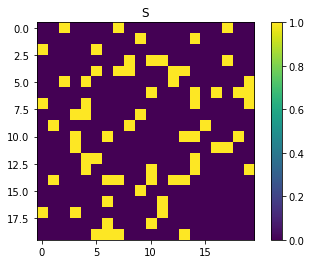

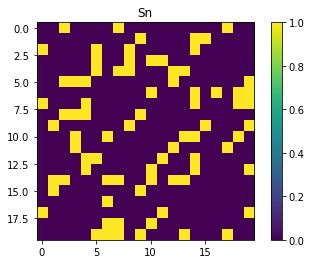

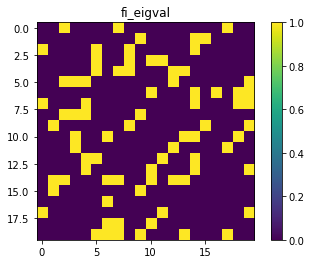

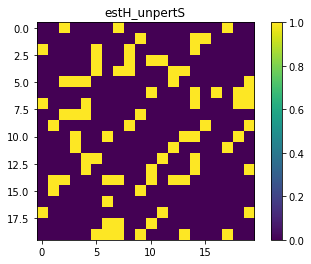

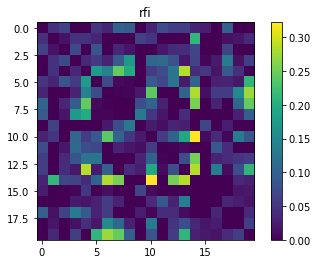

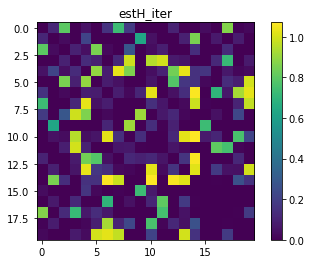

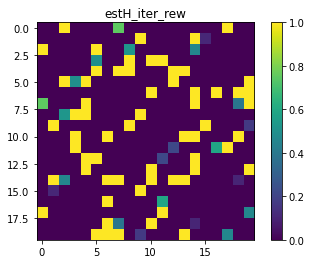

In [6]:
plt.figure()
plt.imshow(S)
plt.colorbar()
plt.title('S')

plt.figure()
plt.imshow(Sn)
plt.colorbar()
plt.title('Sn')

for j, funct in enumerate(funcs):
    if funct in ['ls', 'fi_eigval', 'estH_unpertS']:
        continue
    plt.figure()
    plt.imshow(S_hat[0,j,:,:])
    plt.colorbar()
    plt.title(funct)